In [3]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)
      
    al=0
    
    if(abs(x-y)<t)         
         al=exp(-((x-y)^2)/(omega^2))
         #denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
         #al/=denom
    end
    return al
end

function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
    
    alpha=0.0
    
    if ( abs(x-y) < t) 
        
        alpha=1- (slope*abs(x-y))
        
    end
        
    return alpha
    
end
    

function mc_gt(x::Vector{Float64},y::Vector{Float64},omega::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_gt(x1,y1,omega,t)
        
    end
    return res/(10^6)
    
end

function mc_tri(x::Vector{Float64},y::Vector{Float64},slope::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_tri(x1,y1,slope,t)
        
    end
    return res/(10^6)
    
end

function qgprob(n::Int64)

    #All possible phenotypes
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)

    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .*
                             ind_haplR[1+j,1+q .- (0:q)])
    end

    return R
end



function single_sim(kernel,R, Ng0, Npop)
    
        Np0=Ng0 .*Npop
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end
            
        dat[m,:,:]=Ngen
            
        end
    
    return dat
    
end
        

single_sim (generic function with 1 method)

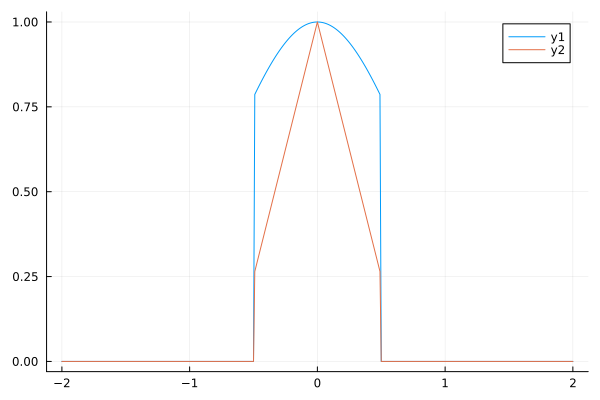

In [5]:
x=0.0
y=collect(-2.0:0.01:2.0)

res=[alpha_gt(x,y[i],1.0,0.5) for i in 1:length(y)]

res2=[alpha_tri(x,y[i],1.5,0.5) for i in 1:length(y)]

plot(y,res)

plot!(y,res2)



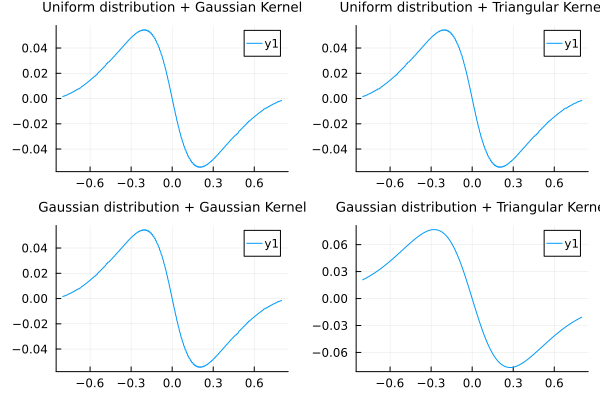

In [4]:
########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

n=100
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.0
slope=1.5
t=0.5
a1=0.5

#Set the mean trait value for species no. 2
means=collect(-0.8:0.005:0.8)

#Pre-calculate coefficients of competition between pairs of phenotypes


A1g=A0g=A1t=A0t=zeros(Float64,nt,nt)

for i1 in 1:nt, i2 in 1:nt
    
    A1g[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A1t[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
end

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)


betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas1,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end


p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9))

plot(p1,p4,p2,p3, layout = (2,2) )

In [ ]:
#Run the long term simulations with different parameter combinations

nsp=20


#traits range between -1 and 1.
n=10
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.0
slope=1.5
t=0.5
a1=0.5

#Pre-calculate coefficients of competition between pairs of phenotypes

A1g=A0g=A1t=A0t=zeros(Float64,nt,nt)

for i1 in 1:nt, i2 in 1:nt
    
    A1g[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A1t[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
end


########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################
N=rand(Uniform(0,1), nsp,nt)

N=[pdf.(Uniform(-0.2,0.2),geno), for i in 1:]

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)


Ng0= N ./ (sum.(eachrow(N)))

Np0= 1000 .* Ng0

Ngen=deepcopy(Ng0)
Np=deepcopy(Np0) 

samples=[collect(0:10:100); collect(100:50:1000)]

result=DataFrame()
#Start the simulation



single_sim(kernel,R, Ng0, Npop)




In [8]:
##Inputs

kernel="Gaussian"
omega=1.0
slope=1.0
t=0.5
n=10
nsp=20
a1=0.5
    
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)

    #Calculate R
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)

    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                                map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
        
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)
        
    #Calculate alpha values
        
    A1=zeros(Float64,nt,nt)
    A0=zeros(Float64,nt,nt)
        
    for i1 in 1:nt, i2 in 1:nt
            
        if (kernel =="Gaussian")
                
                A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
                A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
                
            elseif (kernel=="Triangular")
                
                A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
                A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
            end
    end
    

        
    #Demographic parameters
        
    Npop=1000         #initial pop size of each species. This is necessary since we are incoporating demo. stochasticity
    Ng0=zeros(Float64,nsp,nt)

    #Start with uniformly distributed traits with random means, for each species

    randmean=rand(Uniform(-0.7,0.7),nsp)
    
    for i in 1:nsp
        Ng0[i,:]=pdf.(Uniform(randmean[i]-0.3,randmean[i]+0.3),geno)
        Ng0[i,:]=Ng0[i,:]./sum(Ng0[i,:])

    end

    Np0= Npop .* Ng0 

    #Intrinsic growth rates, range from 0.05 to 0.1 and independent of the trait values
    r=abs.(rand(Uniform(0.05,0.1),nsp))


    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)
    
    dat=zeros(Float64,1000,nsp,nt)
        
    #Start the simulation
    for m in 1:1000
    
        #Determine the extinct species
        Np[findall(sum(Np,dims=2) .< 10),:] .= 0

        if all(sum(Np,dims=2) ==0) 
            break
        else

            newgen=zeros(Float64,nsp,nt)

            #Reproduction event
            for i in 1:size(Ngen)[1]

                probs=Ngen[i,:]*Ngen[i,:]'

                for j in 1:size(R)[3]
                    newgen[i,j]=sum(probs.*R[:,:,j])
                end
            end

            newp=newgen .* sum(Np,dims=2)

            #Selection event

            for i in 1:size(newp)[1], j in 1:size(newp)[2]

                 comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                 Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

            end
            
            Np[findall(Np .<1)] .= 0
            Ngen= Np ./ sum(Np,dims=2)
            
        end
            
        dat[m,:,:]=Ngen
            
        end
    



In [48]:
kernel="Gaussian"
omega=1.0
slope=1.0
t=0.5
n=10
nsp=20
a1=0.5
    
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)

    #Calculate R
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)

    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                                map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
        
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)
        
    #Calculate alpha values
        
    A1=zeros(Float64,nt,nt)
    A0=zeros(Float64,nt,nt)
        
    for i1 in 1:nt, i2 in 1:nt
            
        if (kernel =="Gaussian")
                
                A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
                A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
                
            elseif (kernel=="Triangular")
                
                A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
                A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
            end
    end
    

        
    #Demographic parameters
        
    Npop=1000         #initial pop size of each species. This is necessary since we are incoporating demo. stochasticity
    Ng0=zeros(Float64,nsp,nt)

    #Start with uniformly distributed traits with random means, for each species

    randmean=rand(Uniform(-0.7,0.7),nsp)
    
    for i in 1:nsp
        Ng0[i,:]=pdf.(Uniform(randmean[i]-0.3,randmean[i]+0.3),geno)
        Ng0[i,:]=Ng0[i,:]./sum(Ng0[i,:])

    end

    Np0= Npop .* Ng0 

    #Intrinsic growth rates, range from 0.05 to 0.1 and independent of the trait values
    r=abs.(rand(Uniform(0.05,0.1),nsp))


    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)
    
    dat=zeros(Float64,1000,nsp,nt)
        

for m in 1:1000
    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0
    
    if all(sum(Np,dims=2) ==0) 
        break
    else
    
        newgen=zeros(Float64,nsp,nt)

        #Reproduction event
        for i in 1:size(Ngen)[1]

            probs=Ngen[i,:]*Ngen[i,:]'

            for j in 1:size(R)[3]
                newgen[i,j]=sum(probs.*R[:,:,j])
            end
        end

        newp=newgen .* sum(Np,dims=2)

        #Selection event

        for i in 1:size(newp)[1], j in 1:size(newp)[2]

            comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
            Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

        end

        Np[findall(Np .<1)] .= 0
        Ngen= Np ./ sum(Np,dims=2)
    end
    
    dat[m,:,:]=Np

end   

In [50]:
A1

21×21 Matrix{Float64}:
 0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [35]:
A1[j,:]

101-element Vector{Float64}:
 0.5
 0.49502491687458405
 0.4803947195761616
 0.45696559263561415
 0.42607189448310556
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [19]:
kernel="Gaussian"
omega=1.0
slope=1.0
t=0.5
n=50
nsp=20
a1=0.5
    
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)

    #Calculate R
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)

    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                                map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
        
    geno= collect(range(-5,stop=5,length=2*n+1))
    nt=length(geno)
        
    #Calculate alpha values
        
    A1=zeros(Float64,nt,nt)
    A0=zeros(Float64,nt,nt)
        
    for i1 in 1:nt, i2 in 1:nt
            
        if (kernel =="Gaussian")
                
                A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
                A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
                
            elseif (kernel=="Triangular")
                
                A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
                A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
            end
    end
    

        
    #Demographic parameters
        
    Npop=1000         #initial pop size of each species. This is necessary since we are incoporating demo. stochasticity
    Ng0=zeros(Float64,nsp,nt)

    #Start with uniformly distributed traits with random means, for each species

    randmean=rand(Uniform(-0.7,0.7),nsp)
    
    for i in 1:nsp
        Ng0[i,:]=pdf.(Uniform(randmean[i]-0.3,randmean[i]+0.3),geno)
        Ng0[i,:]=Ng0[i,:]./sum(Ng0[i,:])

    end

    Np0= Npop .* Ng0 

    #Intrinsic growth rates, range from 0.05 to 0.1 and independent of the trait values
    r=abs.(rand(Uniform(0.05,0.1),nsp))


    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)
    
    dat=zeros(Float64,1000,nsp,nt);

In [20]:
newgen=zeros(Float64,nsp,nt)

            #Reproduction event
            for i in 1:size(Ngen)[1]

                probs=Ngen[i,:]*Ngen[i,:]'

                for j in 1:size(R)[3]
                    newgen[i,j]=sum(probs.*R[:,:,j])
                end
            end

            newp=newgen .* sum(Np,dims=2)


20×101 Matrix{Float64}:
 4.93038e-27  4.72002e-25  2.23663e-23  …  1.04919e-25  1.07373e-27
 0.0          0.0          0.0             1.866e-21    2.22648e-23
 1.97215e-28  1.97215e-26  9.76741e-25     1.9754e-24   2.10582e-26
 0.0          0.0          8.76512e-29     3.12436e-23  3.47888e-25
 0.0          0.0          0.0             1.866e-21    2.22648e-23
 0.0          0.0          0.0          …  1.866e-21    2.22648e-23
 2.22648e-23  1.866e-21    7.7293e-20      0.0          0.0
 1.97215e-28  1.97215e-26  9.76741e-25     1.9754e-24   2.10582e-26
 2.10582e-26  1.9754e-24   9.16964e-23     1.97215e-26  1.97215e-28
 2.22648e-23  1.866e-21    7.7293e-20      0.0          0.0
 4.93038e-27  4.72002e-25  2.23663e-23  …  1.04919e-25  1.07373e-27
 2.19128e-29  2.27893e-27  1.17409e-25     7.98485e-24  8.69719e-26
 2.19128e-29  2.27893e-27  1.17409e-25     7.98485e-24  8.69719e-26
 2.22648e-23  1.866e-21    7.7293e-20      0.0          0.0
 1.97215e-28  1.97215e-26  9.76741e-25     1.975

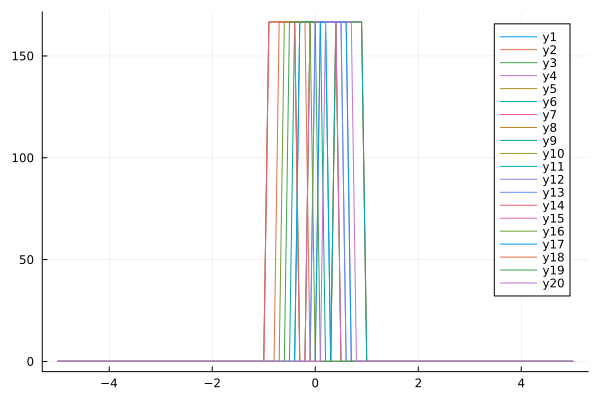

In [21]:
p=plot(geno,Np0[1,:])
for i in 2:nsp
    plot!(geno,Np0[i,:])
end
p

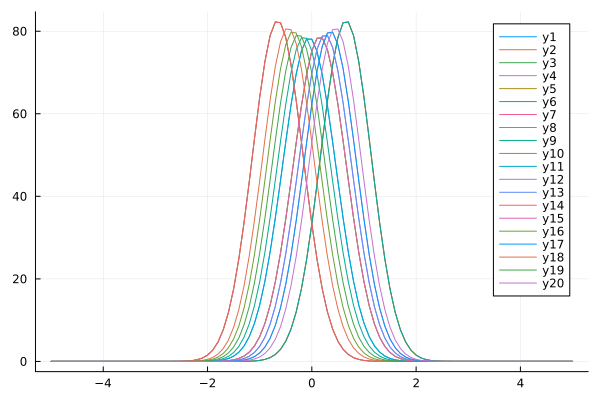

In [29]:
p=plot(geno,newp[1,:])
for i in 2:nsp
    plot!(geno,newp[i,:])
end
p

In [ ]:
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel

n=10
geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.5
slope=1.5
t=2.0
a1=0.5

#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

#Assign probabilities for all phenotypes
N1=pdf.(Uniform(-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

#Assume that mean trait value for species 1 is 0.0.
#Set the mean trait value for species no. 2
means=collect(-4.0:0.005:4.0)

betas1=betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2
    #val=min(means[i],(1.0-means[i]))
    
    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(Uniform(means[i]-1.0,means[i]+1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)

    #N1bar=wsample(geno,N1,1000)
    
    #N2bar=wsample(geno,N2,1000)

    #betas2[i]=mc_gt(N1bar,N2bar,omega,t)
    
end



p1=plot(means,betas1)





In [ ]:
A1

In [ ]:
#no. of loci
n=10

geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end
A1

In [ ]:
#Create a multispecies simulation
#Create a starting population

N=zeros(Float64,nsp,nt)

for i in 1:nsp
    
    smp=sample(-4:1:4)

    N[i,:]=pdf.(Uniform(smp-1.0,smp+1.0),geno)
    
end

#N=rand(Uniform(0,1.0), nsp,nt)
Ng0= N ./ (sum.(eachrow(N)))

res=single_sim(A0,A1,R, Ng0, Npop)

In [ ]:
 Np0=Ng0 .*Npop
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)

 Np[findall(sum(Np,dims=2) .< 10),:] .= 0

 newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

In [ ]:
newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

In [ ]:
A0

In [ ]:
 Np0=Ng0 .*Npop
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end
            
        dat[m,:,:]=Ngen
            
        end
    

In [ ]:
#Case 2: Gaussian traits + truncated gaussian comp. kernel

 n=5
geno= collect(range(-5,stop=5,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.5
slope=1.5
t=2.0
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of phenotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    A0[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    
    #A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

#Assign probabilities for all phenotypes
N1=pdf.(truncated(Normal(0.0,0.5),-1.0,1.0),geno)

N1=N1 ./ sum(N1)

#Assume that mean trait value for species 1 is 0.0.
#Set the mean trait value for species no. 2
means=collect(-4.5:0.05:4.5)

betas1=betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2
    #val=min(means[i],(1.0-means[i]))
    
    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(truncated(Normal(means[i],0.5),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)

    #N1bar=wsample(geno,N1,1000)
    
    #N2bar=wsample(geno,N2,1000)

    #betas2[i]=mc_gt(N1bar,N2bar,omega,t)
    
end


plot(means,betas1)

In [ ]:
geno

In [ ]:
A1

In [ ]:
#Case 3: Uniformly distributed traits + triangular comp. kernel


n=10

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)



omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    #A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],omega,t)
    
    A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end


N1=pdf.(Uniform(-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

means=collect(-5:0.5:5)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)

    N2=pdf.(truncated(Normal(means[i],0.5),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas[i]=sum(newfreq .* geno)

end
plot(means,betas)

In [ ]:
#Case 4: Normally distributed traits + triangluar comp. kernel


n=5

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    #A1[i1,i2]=a1*alpha_gt(geno[i1],geno[i2],omega,t)
    #A0[i1,i2]=alpha_tri(geno[i1],geno[i2],omega,t)
    
    A1[i1,i2]=a1*alpha_tri(geno[i1],geno[i2],slope,t)
    A0[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end


N1=pdf.(truncated(Normal(0.5,0.5),0,1),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

betas=zeros(Float64,length(means))

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))

    #N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)
    N2=pdf.(truncated(Normal(means[i],0.5),0,1),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas[i]=sum(newfreq .* geno)

end
plot(means,betas)

In [ ]:
#Plot beta function shapes by varying a)shapes of trait distributions b)competition kernels

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)

#First use truncated Gaussian competition kernel

omega=0.5
slope=1.5
t=0.5
a1=0.5
        
#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)
        
for i1 in 1:nt, i2 in 1:nt
    
    A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

    A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
end

A1= A1 ./ 100
A0= A0 ./ 100

n=20

geno= collect(range(0,stop=1,length=2*n+1))
nt=length(geno)


    
#Case 1: Uniformly distributed traits

N1=pdf.(Uniform(),geno)
    
N1=N1 ./ sum(N1)

means=collect(0.1:0.01:0.9)

for i in 1:length(means)
    
    val=min(means[i],(1.0-means[i]))
    
    N2=pdf.(Uniform(means[i]-val,means[i]+val),geno)
    
    N2= N2 ./ sum(N2)
    
    
    
    
for i1 in 1:size(newp)[1], i2 in 1:size(newp)[2]
        
        comps=sum(A1[i2,:] .* newp[1:end .!=i1,:]') + sum(A0[i2,:] .* newp[i1,:]) 
        Np[i1,i2]=newp[i1,i2]+(newp[i1,i2]*(1-comps))

end
 




In [ ]:

        
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)
        
#Start the simulation
for m in 1:1000
    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0

    if all(sum(Np,dims=2) ==0) 
        break
        else
        
        newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    

In [ ]:
nsp=2
n=10


geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)
    
    N=ones(Float64, nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    
    result=DataFrame()
        
        omega=0.5
        t=0.5
        a1=0.5
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:100
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

                dat1=DataFrame(nloci=n,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)

        end 
        

    

In [ ]:
result

In [ ]:

function compsim(par::Tuple{Int64, Int64})
    
    rep=par[1]
    n=par[2]

    geno= collect(range(-1,stop=1,length=2*n+1))
    nt=length(geno)
    
    N=rand(Uniform(0,1.0), nsp,nt)
    Ng0= N ./ (sum.(eachrow(N)))
    Np0= 1000 .* Ng0 
    r=abs.(rand(Uniform(0,0.1),nsp))
    
    #Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
    # This code follows the diploid version of an exact hypergeometric model
    #from Shpak and Kondrashov (1999)
    
    haplR=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
        haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                              map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
    end

    for k in 0:n
        haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
        for i1 in 0:n
            haplR[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
            ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
        R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                            ind_haplR[1+j,1+q .- (0:q)])
    end
    
    
    omegas=[0.1,0.5]
    ts=[0.2,0.5,2]
    a1s=[0.1,0.5,1]
    
    result=DataFrame()
        
    for i in omegas, j in ts, k in a1s
        
        omega=i
        t=j
        a1=k
        
        #Pre-calculate coefficients of competition between pairs of genotypes

        A1=zeros(Float64,nt,nt)
        A0=zeros(Float64,nt,nt)
        
        for i1 in 1:nt, i2 in 1:nt
    
            A1[i1,i2]=a1*alpha_gt(geno[i2],geno[i1],omega,t)

            A0[i1,i2]=alpha_gt(geno[i2],geno[i1],omega,t)
    
        end

        A1= A1 ./ 1000
        A0= A0 ./ 1000
        
        
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
            end

            if m ∈ samples

                dat1=DataFrame(nloci=n,reps=rep,omega=omega,t=t,a1=a1,time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))

                append!(result,dat1)
            end

        end 
        
    end
    
    CSV.write(string("compSK_",rep,"_",n,"_",".csv"),result)

end
